#Install Packages

In [ ]:
!pip install geopandas
!pip install holidays

#Import Libraries

In [ ]:
import pandas as pd
import geopandas as gpd

import calendar
import holidays

import plotly.graph_objects as go
import plotly.express as px

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


Connect to Google Drive

In [ ]:
# #Conect Google Drive to import data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Import Dataset

In [ ]:
# Import raw traffic file
path = "/content/drive/MyDrive/MSc_Project_Traffic_Prediction/NZ Traffic Project/01- Data Landscape/NZ_data/"

%load_ext google.colab.data_table

df_traffic_counts_daily = pd.read_csv(path + "TMS_daily_traffic_counts_API.csv")
df_traffic_counts_daily.head()

,OBJECTID,startDate,siteID,regionName,SiteRef,classWeight,siteDescription,laneNumber,flowDirection,trafficCount
0,1,2018/01/01 00:00:00+00,916,11 - Canterbury,07700006,Light,Ashburton - Nth of Racecourse Rd,2,2,504.0
1,2,2018/01/01 00:00:00+00,916,11 - Canterbury,07700006,Light,Ashburton - Nth of Racecourse Rd,1,1,572.0
2,3,2018/01/01 00:00:00+00,2595,14 - Southland,00621171,Light,Btwn Vogel & Durham - Dec,3,2,2189.0
3,4,2018/01/01 00:00:00+00,2595,14 - Southland,00621171,Light,Btwn Vogel & Durham - Dec,4,2,2746.0
4,27,2018/01/01 00:00:00+00,3721,09 - Wellington,01N01011,Heavy,Marycrest,2,2,160.0


#Data Preprocessing

In [ ]:
df_traffic_counts_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4438700 entries, 0 to 4438699
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   OBJECTID         int64  
 1   startDate        object 
 2   siteID           int64  
 3   regionName       object 
 4   SiteRef          object 
 5   classWeight      object 
 6   siteDescription  object 
 7   laneNumber       int64  
 8   flowDirection    int64  
 9   trafficCount     float64
dtypes: float64(1), int64(4), object(5)
memory usage: 338.6+ MB


In [ ]:
#converting to data types
df_traffic_counts_daily['startDate'] = pd.to_datetime(df_traffic_counts_daily['startDate'])
df_traffic_counts_daily['regionName'] = df_traffic_counts_daily['regionName'].astype(str)
df_traffic_counts_daily['SiteRef'] = df_traffic_counts_daily['SiteRef'].astype(str)
df_traffic_counts_daily['classWeight'] = df_traffic_counts_daily['classWeight'].astype(str)
df_traffic_counts_daily['siteDescription'] = df_traffic_counts_daily['siteDescription'].astype(str)

print("\n After Data type conversion \n\n")

df_traffic_counts_daily.info()


 After Data type conversion 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4438700 entries, 0 to 4438699
Data columns (total 10 columns):
 #   Column           Dtype              
---  ------           -----              
 0   OBJECTID         int64              
 1   startDate        datetime64[ns, UTC]
 2   siteID           int64              
 3   regionName       object             
 4   SiteRef          object             
 5   classWeight      object             
 6   siteDescription  object             
 7   laneNumber       int64              
 8   flowDirection    int64              
 9   trafficCount     float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(4)
memory usage: 338.6+ MB


In [ ]:
# Path to shapefile
shapefile_path = path + "shapefiles/State_highway_traffic_monitoring_sites.shp"
gdf_df = gpd.read_file(shapefile_path, crs="EPSG:4326")

In [ ]:
gdf_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2012 entries, 0 to 2011
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    2012 non-null   int64   
 1   SH          2012 non-null   object  
 2   RS          2012 non-null   int64   
 3   RP          2012 non-null   float64 
 4   siteRef     2012 non-null   object  
 5   lane        2012 non-null   object  
 6   type        2012 non-null   object  
 7   percentHea  1901 non-null   float64 
 8   equipmentC  2012 non-null   object  
 9   descriptio  2012 non-null   object  
 10  region      2012 non-null   object  
 11  acceptedDa  1546 non-null   float64 
 12  AADT5years  1889 non-null   float64 
 13  AADT4years  1906 non-null   float64 
 14  AADT3years  1905 non-null   float64 
 15  AADT2years  1921 non-null   float64 
 16  AADT1yearA  1901 non-null   float64 
 17  siteType    2012 non-null   object  
 18  geometry    2012 non-null   geometry
dty

In [ ]:
df_traffic_counts_daily['SiteRef'] = df_traffic_counts_daily['SiteRef'].astype('object')

df_copy = df_traffic_counts_daily.copy()

df_curated = df_copy.merge(gdf_df[['siteRef','SH','siteType','geometry']], left_on = "SiteRef", right_on = "siteRef", how = "left")
df_curated = gpd.GeoDataFrame(df_curated).to_crs("EPSG:4326")

df_curated['date'] = pd.to_datetime(pd.to_datetime(df_curated.startDate).dt.date)
df_curated['week'] = df_curated.date.dt.day_name()
df_curated['month'] = df_curated.date.dt.month
df_curated['year'] = df_curated.date.dt.year

nz_holidays = list(holidays.NewZealand(years = [2018,2019, 2020, 2021, 2022, 2023]).keys())
df_curated['holiday'] = df_curated.date.isin(nz_holidays)
df_curated = df_curated.sort_values("date")

In [ ]:
df_curated.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4438700 entries, 0 to 4428330
Data columns (total 19 columns):
 #   Column           Dtype              
---  ------           -----              
 0   OBJECTID         int64              
 1   startDate        datetime64[ns, UTC]
 2   siteID           int64              
 3   regionName       object             
 4   SiteRef          object             
 5   classWeight      object             
 6   siteDescription  object             
 7   laneNumber       int64              
 8   flowDirection    int64              
 9   trafficCount     float64            
 10  siteRef          object             
 11  SH               object             
 12  siteType         object             
 13  geometry         geometry           
 14  date             datetime64[ns]     
 15  week             object             
 16  month            int64              
 17  year             int64              
 18  holiday          bool             

In [ ]:
df_curated.describe()

,OBJECTID,siteID,laneNumber,flowDirection,trafficCount,month,year
count,4.438700e+06,4.438700e+06,4.438700e+06,4.438700e+06,4.438700e+06,4.438700e+06,4.438700e+06
mean,2.437521e+06,4.657006e+04,1.702455e+00,1.879399e+00,4.187694e+03,6.327745e+00,2.020274e+03
std,1.403972e+06,1.378632e+05,8.345371e-01,1.169545e+00,5.268516e+03,3.459385e+00,1.552298e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.018000e+03
25%,1.213788e+06,5.060000e+02,1.000000e+00,1.000000e+00,3.385000e+02,3.000000e+00,2.019000e+03
50%,2.457976e+06,2.015000e+03,2.000000e+00,2.000000e+00,1.548500e+03,6.000000e+00,2.020000e+03
75%,3.693847e+06,4.501000e+03,2.000000e+00,2.000000e+00,6.635000e+03,9.000000e+00,2.022000e+03
max,4.804027e+06,4.785350e+05,6.000000e+00,6.000000e+00,4.917300e+04,1.200000e+01,2.023000e+03


In [ ]:
df_curated.head()

,OBJECTID,startDate,siteID,regionName,SiteRef,classWeight,siteDescription,laneNumber,flowDirection,trafficCount,siteRef,SH,siteType,geometry,date,week,month,year,holiday
0,1,2018-01-01 00:00:00+00:00,916,11 - Canterbury,07700006,Light,Ashburton - Nth of Racecourse Rd,2,2,504.0,07700006,77,Regional Continuous,POINT (171.73314 -43.85168),2018-01-01,Monday,1,2018,True
730,773,2018-01-01 00:00:00+00:00,2268,02 - Auckland,02010006,Light,SH20 Puhinui Rd On Ramp to Massey Rd Off Ramp NB,1,1,14510.5,02010006,20,Regional Continuous,POINT (174.82951 -36.98210),2018-01-01,Monday,1,2018,True
731,774,2018-01-01 00:00:00+00:00,2268,02 - Auckland,02010006,Light,SH20 Puhinui Rd On Ramp to Massey Rd Off Ramp NB,2,1,10610.0,02010006,20,Regional Continuous,POINT (174.82951 -36.98210),2018-01-01,Monday,1,2018,True
732,775,2018-01-01 00:00:00+00:00,2268,02 - Auckland,02010006,Heavy,SH20 Puhinui Rd On Ramp to Massey Rd Off Ramp NB,2,1,131.0,02010006,20,Regional Continuous,POINT (174.82951 -36.98210),2018-01-01,Monday,1,2018,True
733,776,2018-01-01 00:00:00+00:00,2269,02 - Auckland,02020006,Light,SH20 Puhinui Rd Off Ramp to Massey Rd On Ramp SB,1,2,15631.5,02020006,20,Regional Continuous,POINT (174.82975 -36.98202),2018-01-01,Monday,1,2018,True


#Data Visualization

<ipython-input-18-21d1ac6843f1>:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


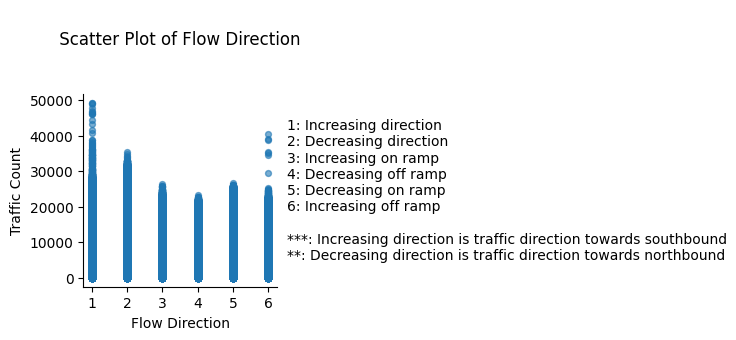

In [ ]:
from matplotlib.ticker import FixedFormatter, FixedLocator

def scatter_plots(df, colname_pairs, scatter_plot_size=2.5, size=18, alpha=.6):
    plt.figure(figsize=(len(colname_pairs) * scatter_plot_size, scatter_plot_size))

    flow_directions = {
        1: "Increasing direction",
        2: "Decreasing direction",
        3: "Increasing on ramp",
        4: "Decreasing off ramp",
        5: "Decreasing on ramp",
        6: "Increasing off ramp\n",
        '***': "Increasing direction is traffic direction towards southbound",
        '**': "Decreasing direction is traffic direction towards northbound"
    }

    # Convert keys to a list of strings
    flow_direction_labels = [str(key) for key in flow_directions.keys() if type(key) == int]

    for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
      ax = plt.subplot(1, len(colname_pairs), plot_i)
      ax.scatter(df[x_colname], df[y_colname], s=size, alpha=alpha)
      plt.title('\n Scatter Plot of Flow Direction \n\n')
      plt.xlabel('Flow Direction')
      plt.ylabel('Traffic Count')
      ax.spines[['top', 'right']].set_visible(False)

      # Create a custom ticker for x-axis
      custom_ticker = FixedLocator(np.arange(1, len(flow_direction_labels) + 1))  # Start from 1
      ax.xaxis.set_major_locator(custom_ticker)
      ax.xaxis.set_major_formatter(FixedFormatter(flow_direction_labels))

      # Set y-axis ticks to show numbers
      ax.get_yaxis().get_major_formatter().set_useOffset(False)

      # Add flow direction descriptions to the right of the plot
      ax.text(1.05, 0.5, "\n".join([f"{key}: {value}" for key, value in flow_directions.items()]),
              transform=ax.transAxes, fontsize=10, va='center')

    plt.tight_layout()
    plt.show()



scatter_plots(df_traffic_counts_daily, [['flowDirection', 'trafficCount']])


In [ ]:
df_traffic_counts_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4438700 entries, 0 to 4438699
Data columns (total 10 columns):
 #   Column           Dtype              
---  ------           -----              
 0   OBJECTID         int64              
 1   startDate        datetime64[ns, UTC]
 2   siteID           int64              
 3   regionName       object             
 4   SiteRef          object             
 5   classWeight      object             
 6   siteDescription  object             
 7   laneNumber       int64              
 8   flowDirection    int64              
 9   trafficCount     float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(4), object(4)
memory usage: 338.6+ MB


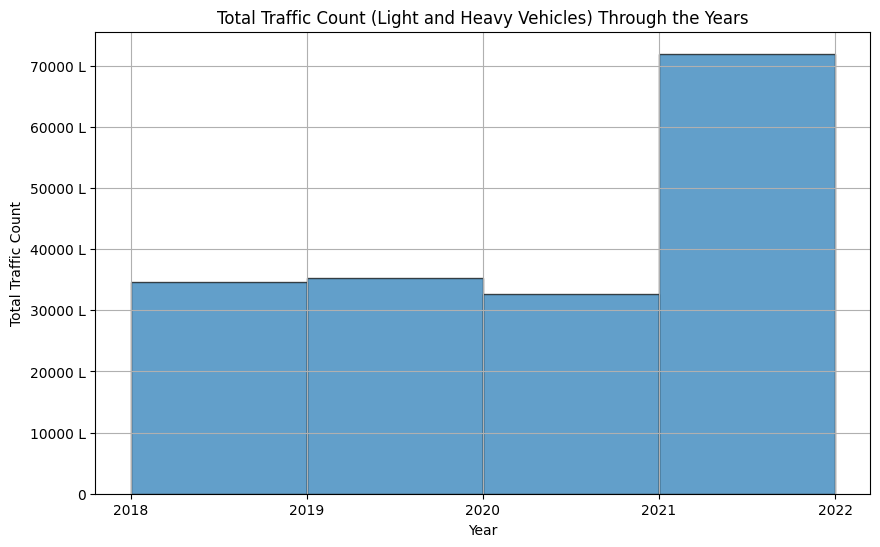

In [ ]:
# Filter data for years less than 2023, and for light and heavy vehicles
filtered_df = df_traffic_counts_daily[(df_traffic_counts_daily['startDate'].dt.year < 2023) & (df_traffic_counts_daily['classWeight'].isin(['Light', 'Heavy']))]

# Group data by year and classWeight, and sum the traffic counts
grouped_by_year = filtered_df.groupby(df_traffic_counts_daily['startDate'].dt.year)['trafficCount'].sum()

# Create a histogram with separate bars for each year
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['startDate'].dt.year, bins=range(min(grouped_by_year.index), max(grouped_by_year.index) + 1),
         weights=filtered_df['trafficCount'], edgecolor='black', alpha=0.7)
plt.title('Total Traffic Count (Light and Heavy Vehicles) Through the Years')
plt.xlabel('Year')
plt.ylabel('Total Traffic Count')
plt.grid(True)

# Format y-axis labels in thousands (K) or lakhs (L)
def format_func(value, tick_number):
    if value >= 100000:
        return f'{value/100000:.0f} L'
    elif value >= 1000:
        return f'{value/1000:.0f} K'
    else:
        return f'{value:.0f}'

plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(format_func))
plt.show()


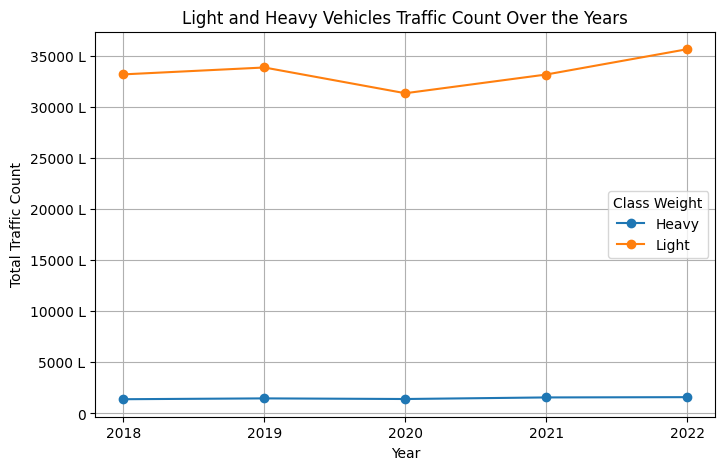

In [ ]:
# Filter data for years less than 2023, and for light and heavy vehicles
filtered_df = df_traffic_counts_daily[(df_traffic_counts_daily['startDate'].dt.year < 2023) & (df_traffic_counts_daily['classWeight'])]

# Group data by year and classWeight, and sum the traffic counts
grouped_by_year_weight = filtered_df.groupby([df_traffic_counts_daily['startDate'].dt.year, 'classWeight'])['trafficCount'].sum().unstack()

# Create line plots
plt.figure(figsize=(8, 5))
grouped_by_year_weight.plot(marker='o', ax=plt.gca())
plt.title('Light and Heavy Vehicles Traffic Count Over the Years')
plt.xlabel('Year')
plt.ylabel('Total Traffic Count')
plt.grid(True)
plt.legend(title='Class Weight')

# Format y-axis labels in thousands (K) or lakhs (L)
def format_func(value, tick_number):
    if value >= 100000:
        return f'{value/100000:.0f} L'
    elif value >= 1000:
        return f'{value/1000:.0f} K'
    else:
        return f'{value:.0f}'

plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(format_func))
plt.show()

In [ ]:
# Group and aggregate the data
plotly_lne_grp = filtered_df.groupby([df_traffic_counts_daily['startDate'].dt.year, "classWeight"]).agg({'trafficCount': 'sum'}).reset_index()

# Stacked area chart
fig_area = px.area(plotly_lne_grp, x='startDate', y='trafficCount', color='classWeight',
                   labels={'year': 'Year', 'trafficCount': 'Number of Vehicles passing'},
                   title='Stacked Area Chart of Vehicles Passing by Year and Class Weight')

fig_area.update_xaxes(tickmode='linear', dtick=1)

# Show the stacked area chart
fig_area.show()

In [ ]:
# Pivot the data to create the image matrix
heatmap_data = plotly_lne_grp.pivot(index='startDate', columns='classWeight', values='trafficCount')

# Define custom colors for 'Light' and 'Heavy' classes
custom_colors = {'Light': 'blue', 'Heavy': 'red'}

# Create the heatmap
fig_heatmap = px.imshow(heatmap_data,
                        labels={'x': 'Class Weight', 'y': 'Start Date', 'color': 'Number of Vehicles passing'},
                        title='Heatmap of Vehicles Passing by Start Date and Class Weight',
                        color_continuous_scale=px.colors.sequential.RdBu)

# Show the heatmap
fig_heatmap.show()

In [ ]:
df_curated.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 4438700 entries, 0 to 4428330
Data columns (total 19 columns):
 #   Column           Dtype              
---  ------           -----              
 0   OBJECTID         int64              
 1   startDate        datetime64[ns, UTC]
 2   siteID           int64              
 3   regionName       object             
 4   SiteRef          object             
 5   classWeight      object             
 6   siteDescription  object             
 7   laneNumber       int64              
 8   flowDirection    int64              
 9   trafficCount     float64            
 10  siteRef          object             
 11  SH               object             
 12  siteType         object             
 13  geometry         geometry           
 14  date             datetime64[ns]     
 15  week             object             
 16  month            int64              
 17  year             int64              
 18  holiday          bool             

In [ ]:
#Map
count_point_loc = df_curated[['siteID','geometry']].drop_duplicates()

# Create a Plotly figure
fig = go.Figure()

# Add scattermapbox trace for the points
fig.add_trace(go.Scattermapbox(
    lat=count_point_loc.geometry.y,
    lon=count_point_loc.geometry.x,
    mode='markers',
    marker=dict(
        size=5,
        color='red'
    ),
    hovertemplate='<b>%{text}</b>',
    text=count_point_loc['siteID']

))

# Update the layout to display the map
fig.update_layout(
    title=dict(
      text='Location Map of Site IDs</b>',
      x=0.5,
      y=0.95
    ),
    mapbox=dict(
        style='open-street-map',
        center=dict(lon=174.885971, lat=-40.900557),
        zoom=5
    ),
    width = 1000, height = 800
)

fig.show()


In [ ]:
# Calculate the traffic density for each point
count_point_loc['trafficDensity'] = count_point_loc.groupby(['siteID'])['siteID'].transform('count')

# Create a Plotly figure
fig = go.Figure()

# Add scattermapbox trace for the points with color based on traffic density
fig.add_trace(go.Scattermapbox(
    lat=count_point_loc.geometry.y,
    lon=count_point_loc.geometry.x,
    mode='markers',
    marker=dict(
        size=10,
        color=count_point_loc['trafficDensity'],
        colorscale='Viridis',  # You can choose other color scales as well
        colorbar=dict(title='Traffic Density')
    ),
    hovertemplate='<b>%{text}</b>',
    text=count_point_loc['siteID']
))

# Update the layout to display the map
fig.update_layout(
    title=dict(
      text='Traffic Density',
      x=0.5,
      y=0.95
    ),
    mapbox=dict(
        style='open-street-map',
        center=dict(lon=174.885971, lat=-40.900557),
        zoom=5
    ),
    width=1000, height=800
)

fig.show()


In [ ]:
# Filter the data frame for years less than 2023
filtered_df = df_curated[df_curated['year'] < 2023]

# Group and aggregate data by 'SH', 'year', and sum of 'trafficCount'
grouped_data = filtered_df.groupby(['SH', 'year'])['trafficCount'].sum().reset_index()

# Create a line chart
fig_line = px.line(grouped_data, x='year', y='trafficCount', color='SH',
                   labels={'year': 'Year', 'trafficCount': 'Total Traffic Count'},
                   title='Traffic Counts by State Highways over the Years')

# Customize the layout
fig_line.update_layout(title={'text': '<b>Traffic Counts by State Highways over the Years</b>',
                              'x': 0.5,  # Center alignment
                              'y': 0.95,  # Adjust vertical position
                              'font': {'family': 'Arial', 'size': 24}})


fig_line.update_xaxes(tickvals=grouped_data['year'].unique(),
                      tickformat="%d",
                      title="<b>Year</b>")  # Use HTML tag to make tick labels bold

fig_line.update_yaxes(title="<b>Total Traffic Count</b>")


# Display the line chart
fig_line.show()

In [ ]:
# Filter the data for 'SH' category '1N' and years less than 2023
filtered_df = df_curated[(df_curated['SH'] == '1N') & (df_curated['year'] < 2023)]

# Group and aggregate data by 'siteID', sum of 'trafficCount'
grouped_data_siteID = filtered_df.groupby('siteID')['trafficCount'].sum().reset_index()

# Sort the data by trafficCount in descending order
sorted_data = grouped_data_siteID.sort_values(by='trafficCount', ascending=False)

# Find the largest and the next five largest traffic counts
largest_traffic_counts = sorted_data.head(1)  # Largest traffic count
next_largest_traffic_counts = sorted_data.iloc[1:6]  # Next five largest traffic counts

# Print the results
print("Largest Traffic Count in SH 1N:")
print(largest_traffic_counts)
print("\nNext Five Largest Traffic Counts in SH 1N:")
print(next_largest_traffic_counts)

Largest Traffic Count in SH 1N:
     siteID  trafficCount
189    2070   135566812.0

Next Five Largest Traffic Counts in SH 1N:
     siteID  trafficCount
191    2073   127240419.0
289    3223   126090578.0
168    2039   120951389.0
179    2055   118872634.0
180    2056   117526417.0


In [ ]:
df_curated[(df_curated['SH'] == '1N') & (df_curated['year'] < 2023)].head()

,OBJECTID,startDate,siteID,regionName,SiteRef,classWeight,siteDescription,laneNumber,flowDirection,trafficCount,siteRef,SH,siteType,geometry,date,week,month,year,holiday
695,738,2018-01-01 00:00:00+00:00,389,02 - Auckland,01N00383,Heavy,Sth of Puhoi Rd,2,2,308.5,01N00383,1N,Regional Continuous,POINT (174.67155 -36.51813),2018-01-01,Monday,1,2018,True
694,737,2018-01-01 00:00:00+00:00,389,02 - Auckland,01N00383,Light,Sth of Puhoi Rd,2,2,10371.5,01N00383,1N,Regional Continuous,POINT (174.67155 -36.51813),2018-01-01,Monday,1,2018,True
817,860,2018-01-01 00:00:00+00:00,3551,02 - Auckland,01N10391,Heavy,SH1 Orewa On Ramp to Millwater On Ramp SB,2,1,44.5,01N10391,1N,Regional Continuous,POINT (174.66235 -36.60189),2018-01-01,Monday,1,2018,True
818,861,2018-01-01 00:00:00+00:00,3551,02 - Auckland,01N10391,Light,SH1 Orewa On Ramp to Millwater On Ramp SB,2,1,6055.5,01N10391,1N,Regional Continuous,POINT (174.66235 -36.60189),2018-01-01,Monday,1,2018,True
819,862,2018-01-01 00:00:00+00:00,3551,02 - Auckland,01N10391,Heavy,SH1 Orewa On Ramp to Millwater On Ramp SB,1,1,396.5,01N10391,1N,Regional Continuous,POINT (174.66235 -36.60189),2018-01-01,Monday,1,2018,True


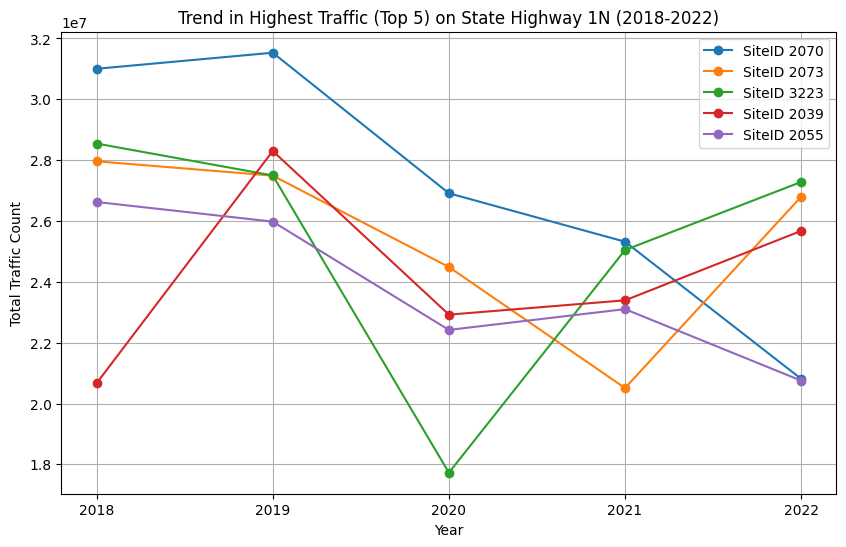

In [ ]:
# Filter the data for 'SH' value '1N' and years from 2018 to 2022
filtered_df = df_curated[(df_curated['SH'] == '1N') & (df_curated['year'].between(2018, 2022))]

# Group and aggregate data by 'siteID', sum of 'trafficCount'
grouped_data = filtered_df.groupby(['siteID', 'year'])['trafficCount'].sum().reset_index()

# Sort the data by 'siteID' and 'trafficCount' to get top 5
top_5_sites = grouped_data.groupby('siteID')['trafficCount'].sum().nlargest(5).index

# Filter the data for the top 5 'siteID' values
top_5_data = grouped_data[grouped_data['siteID'].isin(top_5_sites)]

# Create a line chart to visualize the trend in traffic counts for the top 5 'siteID' values
plt.figure(figsize=(10, 6))
for site_id in top_5_sites:
    data = top_5_data[top_5_data['siteID'] == site_id]
    plt.plot(data['year'], data['trafficCount'], marker='o', label=f'SiteID {site_id}')

plt.xlabel('Year')
plt.ylabel('Total Traffic Count')
plt.title('Trend in Highest Traffic (Top 5) on State Highway 1N (2018-2022)')

# Update x-axis ticks to show integer values
plt.xticks(list(range(2018, 2023)))

plt.legend()
plt.grid(True)
plt.show()


In [ ]:
traffic_siteID = 3223




> Set traffic siteID





In [ ]:
# Filter the data for 'SH' category '1N'
filtered_df_1N = df_curated[(df_curated['SH'] == '1N') & (df_curated.year < 2023)]

# Group and aggregate data by 'siteID', sum of 'trafficCount'
grouped_data_1N = filtered_df_1N.groupby('siteID')['trafficCount'].sum().reset_index()


filtered_df_highest_traffic = filtered_df_1N[filtered_df_1N['siteID'] == traffic_siteID].groupby('year').sum().reset_index()


bar_color = 'crimson'

# bar chart
fig_bar = px.bar(filtered_df_highest_traffic, x='year', y='trafficCount',
                 labels={'year': 'Year', 'trafficCount': 'Total Traffic Count'},
                 title=f'Traffic Count for Site ID: {traffic_siteID} in SH 1N',
                 color_discrete_sequence=[bar_color]
                 )

# Show the bar chart
fig_bar.show()

<ipython-input-8-56f4a8fb1143>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  filtered_df_highest_traffic = filtered_df_1N[filtered_df_1N['siteID'] == traffic_siteID].groupby('year').sum().reset_index()


In [ ]:
print(f"Flow Direction of {traffic_siteID}: ", df_curated.query(f"siteID=={traffic_siteID}")['flowDirection'].unique())

Flow Direction of 3223:  [1]


In [ ]:
#Filter for State highway 1N only
count_point_loc_sh_1N = df_curated.query("SH == '1N'")[['siteID','geometry']].drop_duplicates()

# Create a Plotly figure
fig = go.Figure()

# Add scattermapbox trace for the points
fig.add_trace(go.Scattermapbox(
    lat=count_point_loc_sh_1N.geometry.y,
    lon=count_point_loc_sh_1N.geometry.x,
    mode='markers',
    marker=dict(
        size=5,
        color='red'
    ),
    hovertemplate='<b>%{text}</b>',
    text=count_point_loc_sh_1N['siteID'],
    name="Traffic on Site IDs"
))

# Filter df_curated for siteID
filtered_df_siteId = df_curated[df_curated['siteID'] == traffic_siteID]

fig.add_trace(go.Scattermapbox(
    lat=filtered_df_siteId[['SiteRef','geometry']].drop_duplicates().geometry.y,
    lon=filtered_df_siteId[['SiteRef','geometry']].drop_duplicates().geometry.x,
    mode='markers',
    marker=dict(
        size=5,
        color='blue'
    ),
    hovertemplate='<b>%{text}</b>',
    text=filtered_df_siteId['siteID'],
    name=f"Traffic on Site ID: <b>{filtered_df_siteId['siteID'].iloc[0]}</b>"
))

fig.update_layout(width = 600, height=800,
    title=dict(
    text='<i>Traffic Flow Map of <b>SH 1N</b></i>',
    x=0.5,
    y=0.95
),

    # title='Traffic Flow Map of <b>SH 1N</b>',
    mapbox=dict(
        style='open-street-map',
        center=dict(lon=174.885971, lat=-40.900557),
        zoom=5
    ),
)

# Show the plot
fig.show()


In [ ]:
df_siteID_sample = df_curated.query(f"siteID == {traffic_siteID}").groupby("date").agg({'trafficCount':'sum'}).reset_index()
df_siteID_sample['date'] = pd.to_datetime(df_siteID_sample['date'])

In [ ]:
df_siteID_sample_curated = pd.DataFrame(pd.date_range(start=df_siteID_sample.loc[0,'date'], end = df_siteID_sample.loc[df_siteID_sample.shape[0]-1,'date']),columns=['datetime'])
df_siteID_sample_curated = df_siteID_sample_curated.merge(df_siteID_sample, left_on = ['datetime'], right_on = ['date'], how = 'left')

df_siteID_sample_curated['trafficCount'] = df_siteID_sample_curated['trafficCount'].ffill()
df_siteID_sample_curated = df_siteID_sample_curated.drop("date", axis=1)
df_siteID_sample_curated['week'] = df_siteID_sample_curated.datetime.dt.weekday
df_siteID_sample_curated['month'] = df_siteID_sample_curated.datetime.dt.month
df_siteID_sample_curated['year'] = df_siteID_sample_curated.datetime.dt.year

nz_holidays = list(holidays.NewZealand(years = [2018,2019, 2020, 2021, 2022, 2023]).keys())
df_siteID_sample_curated['holiday'] = df_siteID_sample_curated.datetime.isin(nz_holidays)
df_siteID_sample_curated = df_siteID_sample_curated.sort_values("datetime")


In [ ]:
df_siteID_sample_curated.head()

,datetime,trafficCount,week,month,year,holiday
0,2018-01-01,53353.0,0,1,2018,True
1,2018-01-02,55222.0,1,1,2018,True
2,2018-01-03,67560.0,2,1,2018,False
3,2018-01-04,67560.0,3,1,2018,False
4,2018-01-05,67560.0,4,1,2018,False


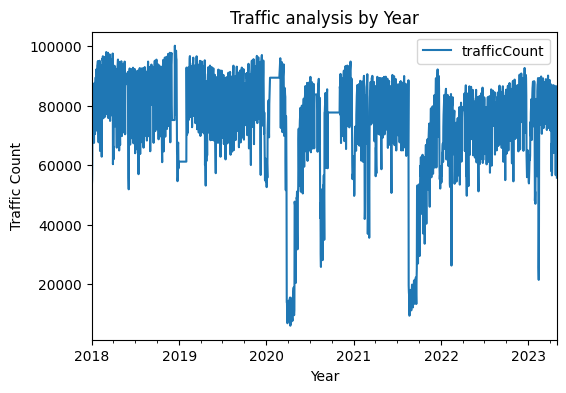

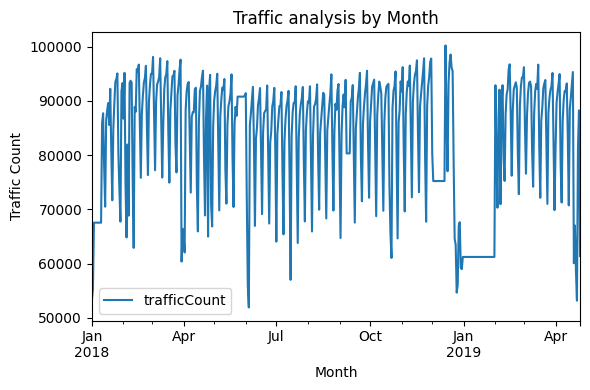

In [ ]:
plot_cols = ['trafficCount']
plot_features = df_siteID_sample_curated[plot_cols]
plot_features.index = df_siteID_sample_curated['datetime']

# Create subplots with labels
fig, ax = plt.subplots(figsize=(6, 4))
plot_features.plot(ax=ax)
ax.set_ylabel('Traffic Count')
ax.set_xlabel('Year')
ax.set_title('Traffic analysis by Year', loc='center')

plot_features = df_siteID_sample_curated[plot_cols][:480]
plot_features.index = df_siteID_sample_curated['datetime'][:480]

# Create subplots with labels
fig, ax = plt.subplots(figsize=(6, 4))
plot_features.plot(ax=ax)
ax.set_ylabel('Traffic Count')
ax.set_xlabel('Month')
ax.set_title('Traffic analysis by Month', loc='center')

plt.tight_layout()

plt.show()


In [ ]:
plotly_lne_grp = df_curated.query(f"siteID == {traffic_siteID} and year<2023").groupby(["year","classWeight"]).agg({'trafficCount':'sum'}).reset_index()

fig = go.Figure()

# Add line traces for the data
fig.add_trace(go.Scatter(
    y=plotly_lne_grp.query("classWeight == 'Light'")['trafficCount'],
    x=plotly_lne_grp.query("classWeight == 'Light'")['year'],
    mode='lines',
    name='Light Vehicles',
))

fig.add_trace(go.Scatter(
    y=plotly_lne_grp.query("classWeight == 'Heavy'")['trafficCount'],
    x=plotly_lne_grp.query("classWeight == 'Heavy'")['year'],
    mode='lines',
    name='Heavy Vehicles',
))

# Update the layout
fig.update_layout(
    title=dict(
      text=f'Site ID : <b>{traffic_siteID}</b>',
        x=0.5,
        y=0.95
    ),
    xaxis=dict(
        title='Year',
        dtick=1
    ),
    yaxis=dict(
        title='Number of Vehicles passing'
    ),
)

# Show the plot
fig.show()

In [ ]:
plotly_lne_grp = df_curated.query(f"siteID == {traffic_siteID} and year<2023").groupby(["date","classWeight"]).agg({'trafficCount':'sum'}).reset_index()
plotly_lne_grp['date'] = pd.to_datetime(plotly_lne_grp.date)
plotly_lne_grp['month'] = plotly_lne_grp.date.dt.month_name()
plotly_lne_grp = plotly_lne_grp.groupby(["classWeight","month"]).median().reset_index()
month = [calendar.month_name[i] for i in range(1,13)]
plotly_lne_grp['month'] = pd.Categorical(plotly_lne_grp['month'],month)
plotly_lne_grp = plotly_lne_grp.sort_values("month")


fig = go.Figure()

# Add line traces for the data
fig.add_trace(go.Scatter(
    y=plotly_lne_grp.query("classWeight == 'Light'")['trafficCount'],
    x=plotly_lne_grp.query("classWeight == 'Light'")['month'],
    mode='lines',
    name='Light Vehicles',
))

fig.add_trace(go.Scatter(
    y=plotly_lne_grp.query("classWeight == 'Heavy'")['trafficCount'],
    x=plotly_lne_grp.query("classWeight == 'Heavy'")['month'],
    mode='lines',
    name='Heavy Vehicles',
))

# Update the layout
fig.update_layout(
    title=dict(
      text=f'Site ID : <b>{traffic_siteID}</b>',
        x=0.5,
        y=0.95
    ),
    xaxis=dict(
        title='Month',
        dtick=1
    ),
    yaxis=dict(
        title='Number of Vehicles passing'
    ),
)

# Show the plot
fig.show()

<ipython-input-24-6baa9ebf9b5d>:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
plotly_lne_grp = df_curated.query(f"siteID == {traffic_siteID}").groupby(["date","classWeight"]).agg({'trafficCount':'sum'}).reset_index()
plotly_lne_grp['date'] = pd.to_datetime(plotly_lne_grp.date)
plotly_lne_grp['week'] = plotly_lne_grp.date.dt.day_name()
plotly_lne_grp = plotly_lne_grp.groupby(["classWeight","week"]).median().reset_index()
week = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
plotly_lne_grp['week'] = pd.Categorical(plotly_lne_grp['week'],week)
plotly_lne_grp = plotly_lne_grp.sort_values("week")

fig = go.Figure()

# Add line traces for the data
fig.add_trace(go.Scatter(
    y=plotly_lne_grp.query("classWeight == 'Light'")['trafficCount'],
    x=plotly_lne_grp.query("classWeight == 'Light'")['week'],
    mode='lines',
    name='Light Vehicles',
))

fig.add_trace(go.Scatter(
    y=plotly_lne_grp.query("classWeight == 'Heavy'")['trafficCount'],
    x=plotly_lne_grp.query("classWeight == 'Heavy'")['week'],
    mode='lines',
    name='Heavy Vehicles',
))

# Update the layout
fig.update_layout(
    title=dict(
      text=f'Site ID : <b>{traffic_siteID}</b>',
        x=0.5,
        y=0.95
    ),
    xaxis=dict(
        title='Week',
        dtick=1
    ),
    yaxis=dict(
        title='Number of Vehicles passing'
    ),
)

# Show the plot
fig.show()

<ipython-input-78-42fc31e5ea47>:4: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [ ]:
df_curated.query(f"siteID == {traffic_siteID}").head()

,OBJECTID,startDate,siteID,regionName,SiteRef,classWeight,siteDescription,laneNumber,flowDirection,trafficCount,siteRef,SH,siteType,geometry,date,week,month,year,holiday
394,436,2018-01-01 00:00:00+00:00,3223,02 - Auckland,01N19424,Heavy,Auckland Harbour Bridge - Classifier Site No 1...,1,1,0.0,01N19424,1N,Regional Continuous,POINT (174.74921 -36.82531),2018-01-01,Monday,1,2018,True
395,437,2018-01-01 00:00:00+00:00,3223,02 - Auckland,01N19424,Light,Auckland Harbour Bridge - Classifier Site No 1...,1,1,0.0,01N19424,1N,Regional Continuous,POINT (174.74921 -36.82531),2018-01-01,Monday,1,2018,True
396,438,2018-01-01 00:00:00+00:00,3223,02 - Auckland,01N19424,Heavy,Auckland Harbour Bridge - Classifier Site No 1...,2,1,0.0,01N19424,1N,Regional Continuous,POINT (174.74921 -36.82531),2018-01-01,Monday,1,2018,True
397,439,2018-01-01 00:00:00+00:00,3223,02 - Auckland,01N19424,Light,Auckland Harbour Bridge - Classifier Site No 1...,2,1,0.0,01N19424,1N,Regional Continuous,POINT (174.74921 -36.82531),2018-01-01,Monday,1,2018,True
403,445,2018-01-01 00:00:00+00:00,3223,02 - Auckland,01N19424,Heavy,Auckland Harbour Bridge - Classifier Site No 1...,5,1,605.0,01N19424,1N,Regional Continuous,POINT (174.74921 -36.82531),2018-01-01,Monday,1,2018,True



---
> Generate Csv Traffic SiteID




In [ ]:
df_curated_siteId = df_curated.query(f"siteID == {traffic_siteID}")
df_curated_siteId = df_curated_siteId.drop(['classWeight','laneNumber','OBJECTID'],axis=1)
df_curated_siteId = df_curated_siteId.drop_duplicates().reset_index(drop=True)

df_siteId_grp = df_curated_siteId.groupby("startDate").agg({'trafficCount':'sum'})
df_curated_siteId = df_curated_siteId.drop(['trafficCount'],axis=1)

df_curated_siteId.merge(df_siteId_grp, left_on = 'startDate', right_on = df_siteId_grp.index).to_csv(path + f'artifacts/curated_data_siteID_{traffic_siteID}.csv', index=False)

In [ ]:
df_curated_siteId.head()

,startDate,siteID,regionName,SiteRef,siteDescription,flowDirection,siteRef,SH,siteType,geometry,date,week,month,year,holiday
0,2018-01-01 00:00:00+00:00,3223,02 - Auckland,01N19424,Auckland Harbour Bridge - Classifier Site No 1...,1,01N19424,1N,Regional Continuous,POINT (174.74921 -36.82531),2018-01-01,Monday,1,2018,True
1,2018-01-01 00:00:00+00:00,3223,02 - Auckland,01N19424,Auckland Harbour Bridge - Classifier Site No 1...,1,01N19424,1N,Regional Continuous,POINT (174.74921 -36.82531),2018-01-01,Monday,1,2018,True
2,2018-01-01 00:00:00+00:00,3223,02 - Auckland,01N19424,Auckland Harbour Bridge - Classifier Site No 1...,1,01N19424,1N,Regional Continuous,POINT (174.74921 -36.82531),2018-01-01,Monday,1,2018,True
3,2018-01-01 00:00:00+00:00,3223,02 - Auckland,01N19424,Auckland Harbour Bridge - Classifier Site No 1...,1,01N19424,1N,Regional Continuous,POINT (174.74921 -36.82531),2018-01-01,Monday,1,2018,True
4,2018-01-01 00:00:00+00:00,3223,02 - Auckland,01N19424,Auckland Harbour Bridge - Classifier Site No 1...,1,01N19424,1N,Regional Continuous,POINT (174.74921 -36.82531),2018-01-01,Monday,1,2018,True
